In [1]:
using ImageView, Phylo, Plots, FASTX, MolecularEvolution, CodonMolecularEvolution, JLD2, MCMCChains, StatsPlots, MCMCDiagnosticTools, Measures, BenchmarkTools

In [24]:
analysis_name = "output/Ace2"
seqnames,seqs = read_fasta("../test/data/Ace2_tiny/Ace2_tiny_tagged.fasta");
treestring = readlines(open("../test/data/Ace2_tiny/tiny_tagged_no_bg.tre"))[1]
tags = ["{G1}", "{G2}"]
#treestring, tags, tag_colors = import_colored_figtree_nexus_as_tagged_tree("../test/data/Ace2_tiny/Ace2_tiny_tagged_no_bg_tags_flipped.nex")
df,results = difFUBAR(seqnames, seqs, treestring, tags, analysis_name);
print(typeof(results))
diffubar_alloc_grid = results[1]
diffubar_codon_param_vec = results[2]

Step 1: Initialization. If exports = true, tree showing the assignment of branches to groups/colors will be exported to: output/Ace2_tagged_input_tree.svg.
Step 2: Optimizing global codon model parameters.
Optimized single α,β LL=-17461.80292552851 with α=1.688175953772318 and β=0.830522823141943.
Step 3: Calculating grid of 1728-by-808 conditional likelihood values (the slowest step). Currently on:
0.0% 29.0% 58.0% 87.0% 
Step 4: Running Gibbs sampler to infer site categories.
Step 5: Tabulating and plotting. Detected sites:
Site 3 - P(ω1 > ω2):0.009; P(ω2 > ω1):0.962; P(ω1 > 1):0.173; P(ω2 > 1):0.9215
Site 29 - P(ω1 > ω2):0.974; P(ω2 > ω1):0.0015; P(ω1 > 1):0.9755; P(ω2 > 1):0.17
Site 36 - P(ω1 > ω2):0.9705; P(ω2 > ω1):0.0025; P(ω1 > 1):0.903; P(ω2 > 1):0.225
Site 45 - P(ω1 > ω2):0.0125; P(ω2 > ω1):0.955; P(ω1 > 1):0.1385; P(ω2 > 1):0.862
Site 68 - P(ω1 > ω2):0.9705; P(ω2 > ω1):0.003; P(ω1 > 1):0.362; P(ω2 > 1):0.016
Site 69 - P(ω1 > ω2):0.2985; P(ω2 > ω1):0.2925; P(ω1 > 1):0.9645; P

1728-element Vector{Vector{Float64}}:
 [0.009999999999999995, 0.009999999999999995, 0.009999999999999995]
 [0.009999999999999995, 0.009999999999999995, 0.046677243358155304]
 [0.009999999999999995, 0.009999999999999995, 0.10577482305553314]
 [0.009999999999999995, 0.009999999999999995, 0.20099800796022266]
 [0.009999999999999995, 0.009999999999999995, 0.3544299249663776]
 [0.009999999999999995, 0.009999999999999995, 0.6016528379549163]
 [0.009999999999999995, 0.009999999999999995, 1.0]
 [0.009999999999999995, 0.009999999999999995, 1.6418517587677186]
 [0.009999999999999995, 0.009999999999999995, 2.67605940347183]
 [0.009999999999999995, 0.009999999999999995, 4.342465139303896]
 ⋮
 [11.353924664211041, 11.353924664211041, 0.20099800796022266]
 [11.353924664211041, 11.353924664211041, 0.3544299249663776]
 [11.353924664211041, 11.353924664211041, 0.6016528379549163]
 [11.353924664211041, 11.353924664211041, 1.0]
 [11.353924664211041, 11.353924664211041, 1.6418517587677186]
 [11.3539246642

In [44]:
include("../src/difFUBAR/skbDifFUBAR.jl")

hypothesis_posterior_probabilities (generic function with 1 method)

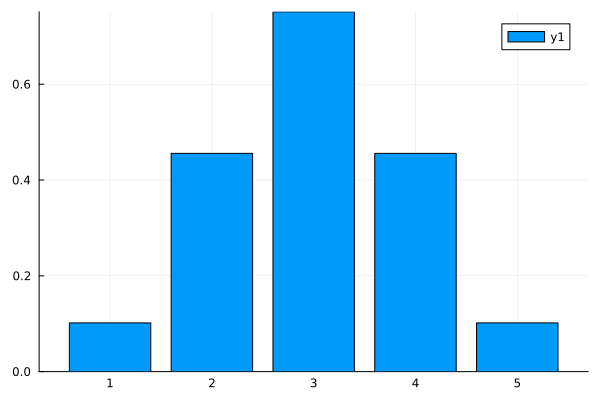

In [4]:
# Seeing if I indeed get a gaussian kernel
a = gaussian_kernel(5, 1.0)#generate_box_blur_kernel(1.0, 4)
bar(a) #LGTM

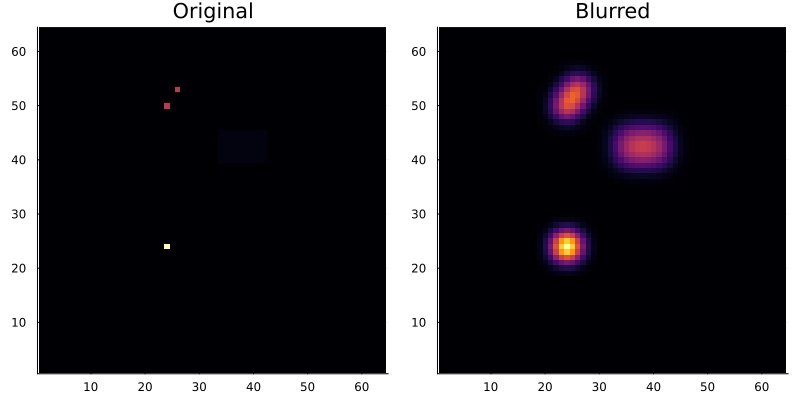

In [5]:
# Example input array (2D for visualization)
x = zeros(64, 64)
x[24, 24] = 2
x[40:45, 34:42] .= 2 / (5*8)
x[50, 24] = 1
x[53, 26] = 1
# Suppose generate_box_blur_kernel and apply_separable_convolution are defined elsewhere:
kernel = gaussian_kernel(12, 4.0)#generate_box_blur_kernel(4.0, 4)
blurred = apply_separable_convolution(x, kernel)

# Plot side-by-side with titles
plot(
    heatmap(x, title="Original", colorbar=false, aspect_ratio=:equal),
    heatmap(blurred, title="Blurred", colorbar=false, aspect_ratio=:equal),
    layout = (1, 2),
    size = (800, 400)
)

## We should get a gaussian slice here...

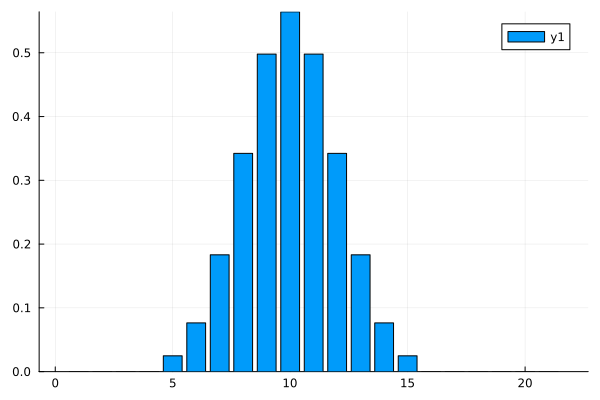

In [5]:
bar(blurred[24, 15:35])

In [45]:
@load "../src/difFUBAR/output/alloc_grid.jld2" alloc_grid
@load "../src/difFUBAR/output/ambient_samples.jld2" ambient_samples
@load "../src/difFUBAR/output/model.jld2" model_dict 
println(size(ambient_samples))
println(size(ambient_samples[1]))

(8,)
(200,)


In [46]:
square_distance_matrix = generate_square_l2_distance_matrix(model_dict[:codon_param_index_vec])
kernel_stddev = 0.05 # example values idk what these should be xD
kernel_stddev_mat = 1.0#[1.0 0.0; 0.0 10.0]
suppression_stddev = 1.0
grid_sizes = zeros(Int64, length(model_dict[:codon_param_index_vec][1]))
for i = 1:length(model_dict[:codon_param_index_vec][1])
    grid_sizes[i] = maximum([index[i] for index in model_dict[:codon_param_index_vec]])
end
grid_sizes = Tuple(grid_sizes)
model = SKBDIModel(
    model_dict[:parameter_grids],
    model_dict[:parameter_names],
    model_dict[:hypothesis_masks],
    s -> CodonMolecularEvolution.quintic_smooth_transition(0, 1, s),
    model_dict[:log_con_lik_matrix],
    model_dict[:con_lik_matrix],
    model_dict[:codon_param_vec],
    model_dict[:codon_param_index_vec],
    s -> grid_based_ambient_to_parameter_transform(
                s,
                grid_sizes,
                model_dict[:kernel_dim],
                model_dict[:suppression_dim],
                kernel_stddev,
                suppression_stddev),
    1,
    grid_sizes
    )

SKBDIModel([[0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.05, 0.13001028718392543, 0.274037034920393, 0.533299997142476, 1.0, 1.8401080154312168, 3.3523888666641257]], ["alpha", "omega_1", "omega_2", "background_omega"], Bool[0 0 … 1 1; 0 0 … 1 1; 0 0 … 1 0; 0 1 … 0 0], var"#191#193"(), [-3.839148149233197 -30.344841971494223 … -47.94618820418001 -23.334255449792952; -3.839903648760521 -30.345284496506352 … -47.94670336703331 -23.334784343782978; … ; -91.26655799030225 -95.33044430147183 … -99.89358205430005 -87.84306700056084; -97.66354877162979 -101.84133794671169 … -107.11749

In [47]:
#= ambient_sample_mat = reduce(hcat, ambient_samples)
ambient_sample_mat = permutedims(ambient_sample_mat, (2, 1))        # 3D: iterations × parameters × chains
ambient_sample_mat = reshape(ambient_sample_mat, size(ambient_sample_mat)..., 1) =#
n_chains = length(ambient_samples)
n_iters = length(ambient_samples[1])
n_params = length(ambient_samples[1][1])
ambient_sample_mat = Array{Float64}(undef, n_iters, n_params, n_chains)
for c in 1:n_chains
    for i in 1:n_iters
        ambient_sample_mat[i, :, c] = ambient_samples[c][i]
    end
end

In [48]:
n_ll = min(100, n_iters)
LL_lists = zeros(Float64, n_chains, n_ll)
for i = 1:n_chains
    LL_lists[i, 1:n_ll] = [log_likelihood(model, s) for s in ambient_samples[i][1:n_ll]]
end


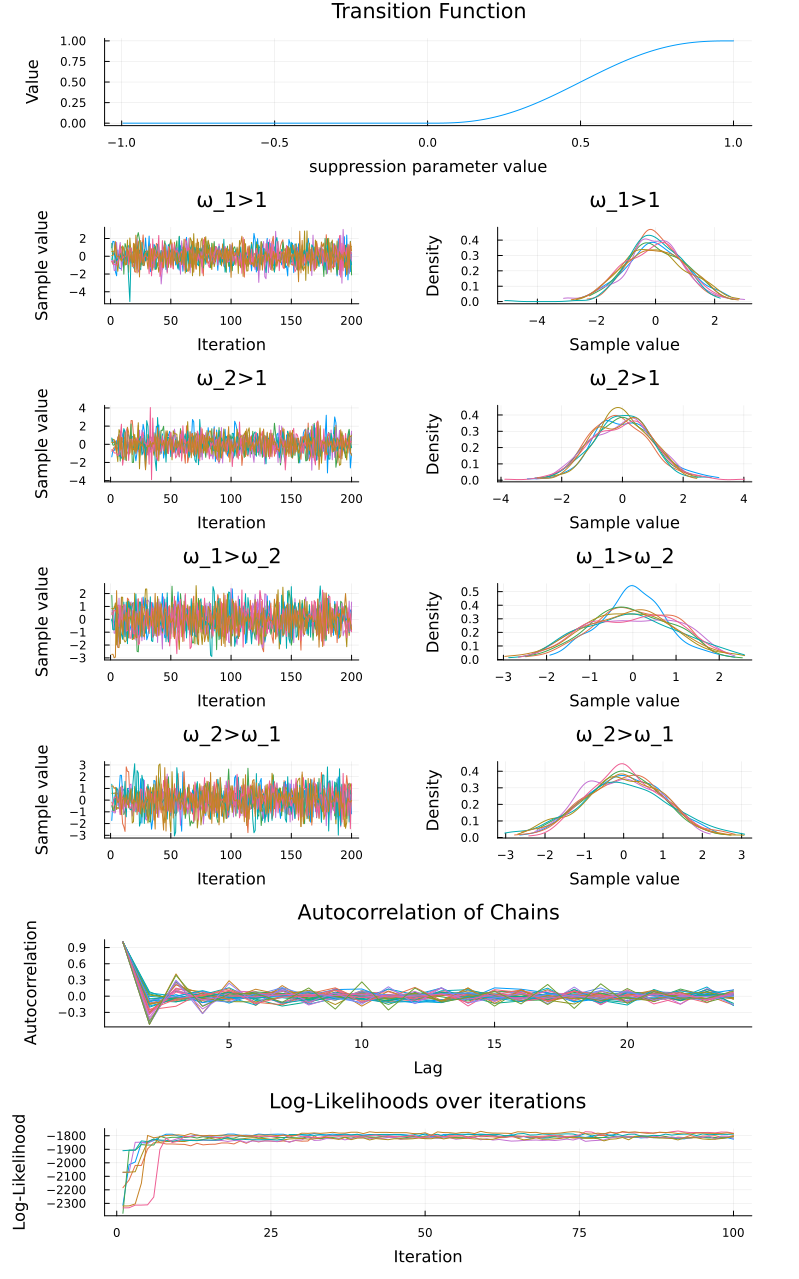

In [49]:
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, 0, 1)
s_values = -1 .+ 2/ 500 .* (1:500) 
F_values = F.(s_values)
hypothesis_names = ["ω_1>1", "ω_2>1", "ω_1>ω_2", "ω_2>ω_1"]
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, 0, 1)
p1 = plot(s_values, F_values, label="F(s)", title="Transition Function", xlabel="suppression parameter value", ylabel="Value")
chn = Chains(ambient_sample_mat[:, model_dict[:kernel_dim] + 1:model_dict[:kernel_dim] + model_dict[:suppression_dim], :], hypothesis_names)
p2 = plot(chn)
p3 = plot(autocor(chn[hypothesis_names[1]]), title="Autocorrelation of Chains", xlabel="Lag", ylabel="Autocorrelation")
for i in 2:length(hypothesis_names)
    plot!(autocor(chn[hypothesis_names[i]]))
end
p4 = plot(1:n_ll, LL_lists[1, :],legend=false, title="Log-Likelihoods over iterations", xlabel="Iteration", ylabel="Log-Likelihood")
for i = 2:n_chains
plot!(1:n_ll, LL_lists[i, :])
end
plot(p1, p2, p3,p4, legend=false,layout = @layout([a{0.1h}; b; c{0.1h}; d{0.1h}]), size =(800, 1.6 * 800), left_margin = 10mm,  right_margin = 10mm)
#savefig("mcmc_diagnostics_nuts.pdf")

In [50]:
probabilities = 1:model_dict[:suppression_dim]
for j = 1:n_chains
    println("Chain ", j, ":")
for i = 1:model_dict[:suppression_dim]
    println("P(F(s) > 0) for hypothesis ", hypothesis_names[i], ") = ", mean(F.(ambient_sample_mat[j, :, model.kernel_dim+1:model.kernel_dim+model.suppression_dim] .> 0)))
end
end

Chain 1:
P(F(s) > 0) for hypothesis ω_1>1) = 0.503606462781304
P(F(s) > 0) for hypothesis ω_2>1) = 0.503606462781304
P(F(s) > 0) for hypothesis ω_1>ω_2) = 0.503606462781304
P(F(s) > 0) for hypothesis ω_2>ω_1) = 0.503606462781304
Chain 2:
P(F(s) > 0) for hypothesis ω_1>1) = 0.4969705712637046
P(F(s) > 0) for hypothesis ω_2>1) = 0.4969705712637046
P(F(s) > 0) for hypothesis ω_1>ω_2) = 0.4969705712637046
P(F(s) > 0) for hypothesis ω_2>ω_1) = 0.4969705712637046
Chain 3:
P(F(s) > 0) for hypothesis ω_1>1) = 0.49307559145989616
P(F(s) > 0) for hypothesis ω_2>1) = 0.49307559145989616
P(F(s) > 0) for hypothesis ω_1>ω_2) = 0.49307559145989616
P(F(s) > 0) for hypothesis ω_2>ω_1) = 0.49307559145989616
Chain 4:
P(F(s) > 0) for hypothesis ω_1>1) = 0.4923542989036353
P(F(s) > 0) for hypothesis ω_2>1) = 0.4923542989036353
P(F(s) > 0) for hypothesis ω_1>ω_2) = 0.4923542989036353
P(F(s) > 0) for hypothesis ω_2>ω_1) = 0.4923542989036353
Chain 5:
P(F(s) > 0) for hypothesis ω_1>1) = 0.49610502019619157
P(F

In [41]:
f = (i, j) -> mean([F(ambient_samples[k][model_dict[:kernel_dim] + i]) > 0 for k in 1:j])
p1 = plot(1:10000, f.(1, 1:100), label=hypothesis_names[1], title="P(F(s) > 0) for each hypothesis")
for i in 2:model_dict[:suppression_dim]
    plot!(1:10000, f.(i, 1:100), label=hypothesis_names[i])
end
display(p1)

MethodError: MethodError: no method matching isless(::Vector{Float64}, ::Int64)
The function `isless` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  isless(!Matched::NLopt.Result, ::Integer)
   @ NLopt C:\Users\toven\.julia\packages\NLopt\ZvUrS\src\NLopt.jl:151
  isless(!Matched::DataValues.DataValue{Union{}}, ::Any)
   @ DataValues C:\Users\toven\.julia\packages\DataValues\N7oeL\src\scalar\core.jl:293
  isless(::Any, !Matched::DataValues.DataValue{Union{}})
   @ DataValues C:\Users\toven\.julia\packages\DataValues\N7oeL\src\scalar\core.jl:291
  ...


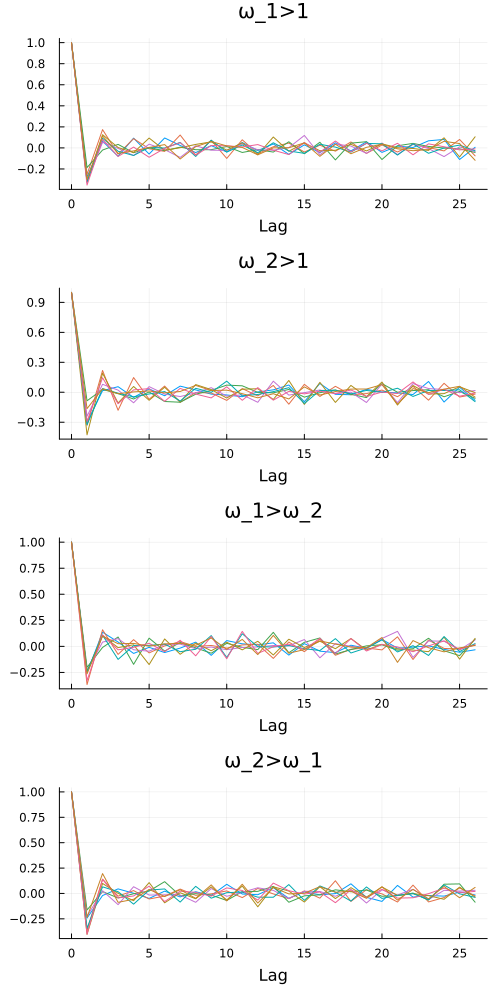

In [17]:
autocorplot(chn)

In [51]:
skbi_posterior_probabilities = hypothesis_posterior_probabilities(alloc_grid, model.codon_param_vec)
diffubar_posterior_probabilities = hypothesis_posterior_probabilities(diffubar_alloc_grid, diffubar_codon_param_vec)

808×4 Matrix{Float64}:
 0.0645  0.0995  0.281   0.3315
 0.701   0.2775  0.775   0.091
 0.173   0.9215  0.009   0.962
 0.045   0.0185  0.6165  0.1585
 0.8085  0.831   0.166   0.4135
 0.094   0.11    0.325   0.3385
 0.221   0.27    0.3685  0.476
 0.7245  0.5715  0.482   0.221
 0.0895  0.4085  0.1055  0.771
 0.1255  0.555   0.0945  0.809
 ⋮                       
 0.263   0.095   0.779   0.0805
 0.618   0.1945  0.7965  0.029
 0.2545  0.436   0.1525  0.57
 0.1645  0.247   0.3295  0.3905
 0.0195  0.1565  0.091   0.762
 0.0295  0.033   0.2885  0.2875
 0.005   0.0105  0.251   0.2335
 0.0     0.001   0.299   0.242
 0.1335  0.061   0.6515  0.1595

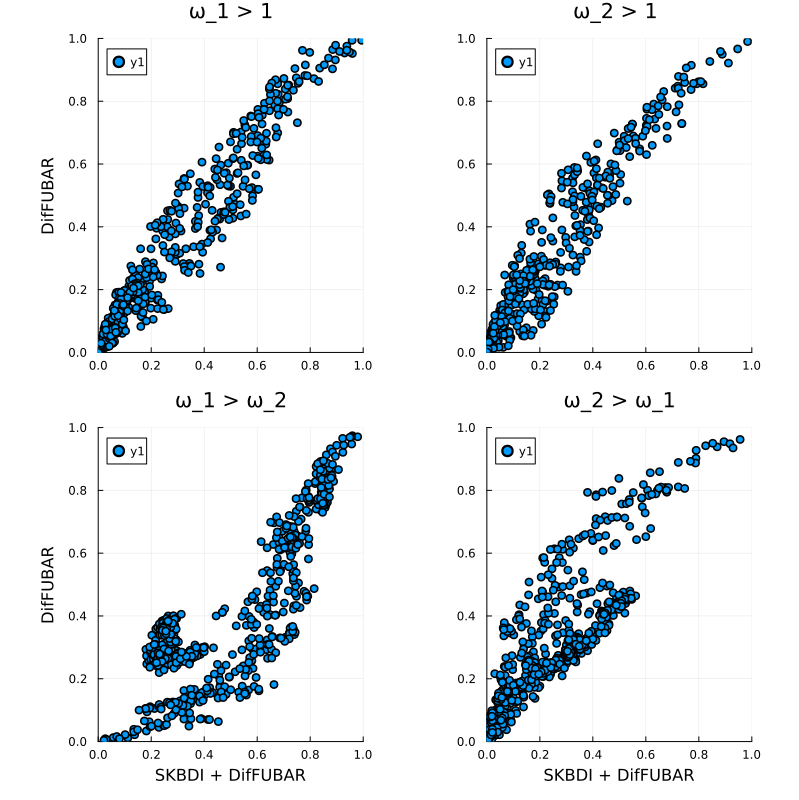

In [52]:
p1 = scatter(skbi_posterior_probabilities[:, 1], diffubar_posterior_probabilities[:, 1], title="ω_1 > 1", ylabel="DifFUBAR",limits=(0, 1))
p2 = scatter(skbi_posterior_probabilities[:, 2], diffubar_posterior_probabilities[:, 2], title="ω_2 > 1 ", limits=(0, 1))
p3 = scatter(skbi_posterior_probabilities[:, 3], diffubar_posterior_probabilities[:, 3], xlabel="SKBDI + DifFUBAR", title="ω_1 > ω_2", ylabel="DifFUBAR", limits=(0, 1))
p4 = scatter(skbi_posterior_probabilities[:, 4], diffubar_posterior_probabilities[:, 4], xlabel="SKBDI + DifFUBAR", title="ω_2 > ω_1", limits=(0, 1))
plot(p1, p2, p3, p4, layout = @layout([a b; c d]), size =(800, 800), left_margin = 10mm,  right_margin = 10mm)
#savefig("difFUBAR_vs_SKBDI_posterior_probabilities.pdf")

In [20]:
ambient_samples[1:2]

2-element Vector{Any}:
 [[1.0250296462542727, 0.8009382463438726, -0.7091487003381749, -2.774156032021552, 0.7827389777402588, 2.382266502271367, 0.7450102856118368, -0.5958270615534427, 0.5287464042785542, 0.8898037064869241  …  -1.1704224616434062, -0.7281650523861217, -0.6305889012803715, -0.6925327894821246, -1.498308720530125, -0.7020805771185769, -0.44862357594839286, -0.8480057975688782, 0.11763919041698442, -0.5157849517326574], [1.5064886575233127, 0.9886633261258875, 0.050671173428047785, -2.054429441938719, 1.5761760801516431, 1.2198548146198067, 1.737094234446323, -1.4258853758980856, 0.48215739752615344, 0.6030141560317802  …  0.04987718416080115, -0.10717263830845339, -0.967382664542349, -1.7696428511227102, -1.0694031609538897, -1.0874883578412606, 1.2098957829715329, 0.21181564160356217, -0.027382981732640047, -0.08562606847766985], [1.111106563555272, 1.1148296097755483, 0.10672150043914684, -2.051734028517956, 1.7165705903049282, 0.8988891264932712, 1.5312711530757828

In [25]:
stop = 2
println("timing ambient_to_parameter_transform")
@btime model.ambient_to_parameter_transform.(ambient_samples[1][50:50 + stop])
f = s -> to_probability_vector(model, s)
println("timing to_probability_vector (ambient_to_parameter_transform + some other stuff)")
@btime a = f.(ambient_samples[1][50:50 + stop])
g = s -> log_likelihood(model, s)
println("timing log_likelihood (to_probability_vector + multiplication by con_lik_matrix)")
@btime b = g.(ambient_samples[1][50:50 + stop])
#print(count([count(a[i] .> 0.0) == 84 for i in 1:500])) 


timing ambient_to_parameter_transform
  1.038 ms (78143 allocations: 4.38 MiB)
timing to_probability_vector (ambient_to_parameter_transform + some other stuff)
  1.124 ms (78454 allocations: 4.87 MiB)
timing log_likelihood (to_probability_vector + multiplication by con_lik_matrix)
  1.691 ms (78481 allocations: 4.91 MiB)


3-element Vector{Float64}:
 -1770.4525587361954
 -1763.897586926753
 -1763.0832677188123

In [ ]:
@btime(log_likelihood())

In [20]:
model2 = SKBDIModel(
    model_dict[:parameter_grids],
    model_dict[:parameter_names],
    model_dict[:hypothesis_masks],
    s -> CodonMolecularEvolution.quintic_smooth_transition(-1, 1, s),
    model_dict[:log_con_lik_matrix],
    model_dict[:con_lik_matrix],
    model_dict[:codon_param_vec],
    model_dict[:codon_param_index_vec],
    s -> toves_ambient_to_parameter_transform(s, model.kernel_dim, model.suppression_dim, kernel_stddev, suppression_stddev, square_distance_matrix, toves_weight_function),
    1,
    grid_sizes
    )

SKBDIModel([[0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.05, 0.13001028718392543, 0.274037034920393, 0.533299997142476, 1.0, 1.8401080154312168, 3.3523888666641257]], ["alpha", "omega_1", "omega_2", "background_omega"], Bool[0 0 … 1 1; 0 0 … 1 1; 0 0 … 1 0; 0 1 … 0 0], var"#92#94"(), [-3.839148149233197 -30.344841971494223 … -47.94618820418001 -23.334255449792952; -3.839903648760521 -30.345284496506352 … -47.94670336703331 -23.334784343782978; … ; -91.26655799030225 -95.33044430147183 … -99.89358205430005 -87.84306700056084; -97.66354877162979 -101.84133794671169 … -107.1174977

In [14]:
model3 = SKBDIModel(
    model_dict[:parameter_grids],
    model_dict[:parameter_names],
    model_dict[:hypothesis_masks],
    s -> CodonMolecularEvolution.quintic_smooth_transition(-1, 1, s),
    model_dict[:log_con_lik_matrix],
    model_dict[:con_lik_matrix],
    model_dict[:codon_param_vec],
    model_dict[:codon_param_index_vec],
    s -> hedwigs_ambient_to_parameter_transform(s, model.kernel_dim, model.suppression_dim, kernel_stddev, suppression_stddev, square_distance_matrix, fast_cov_mat_hedwigs_kernel),
    1,
    grid_sizes
    )

SKBDIModel([[0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.009999999999999995, 0.046677243358155304, 0.10577482305553314, 0.20099800796022266, 0.3544299249663776, 0.6016528379549163, 1.0, 1.6418517587677186, 2.67605940347183, 4.342465139303896, 7.027523686911609, 11.353924664211041], [0.05, 0.13001028718392543, 0.274037034920393, 0.533299997142476, 1.0, 1.8401080154312168, 3.3523888666641257]], ["alpha", "omega_1", "omega_2", "background_omega"], Bool[0 0 … 1 1; 0 0 … 1 1; 0 0 … 1 0; 0 1 … 0 0], var"#88#90"(), [-3.839148149233197 -30.344841971494223 … -47.94618820418001 -23.334255449792952; -3.839903648760521 -30.345284496506352 … -47.94670336703331 -23.334784343782978; … ; -91.26655799030225 -95.33044430147183 … -99.89358205430005 -87.84306700056084; -97.66354877162979 -101.84133794671169 … -107.1174977

In [23]:
stop = 2
models = [model3, model2, model]
model_names = ["Krylov Matrix Sqrt","Weight Matrix (no grid)", "Weight Matrix (grid)"]


input = ambient_samples[1][1:1 + stop]
println("Log likelihood benchmark :D")
for i in 1:3
    let
        m = models[i]
        println("Model: ", model_names[i])

        # === Warm-ups ===
        #_ = m.ambient_to_parameter_transform(input[1])
        #_ = to_probability_vector(m, input[1])
        _ = log_likelihood(m, input[1])

        # === Benchmarks ===
        #println("ambient_to_parameter_transform:")
        #@btime $m.ambient_to_parameter_transform($input[1])

        #println("to_probability_vector (1 sample):")
        #@btime to_probability_vector($m, $input[1])

        #println(":")
        @btime log_likelihood($m, $input[1])
    end
end

Log likelihood benchmark :D
Model: Krylov Matrix Sqrt
  57.635 ms (239 allocations: 46.22 MiB)
Model: Weight Matrix (no grid)
  68.429 ms (144 allocations: 68.57 MiB)
Model: Weight Matrix (grid)
  589.300 μs (26156 allocations: 1.64 MiB)


In [22]:
34 / 36

0.9444444444444444